In [1]:
import tensorflow as tf

url = 'https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip'
name = 'fruits360'
file = tf.keras.utils.get_file(name,url,extract=True)

795435008/Unknown - 32s 0us/step

In [2]:
import os

# 指定訓練資料夾目錄
training_path = os.path.sep.join(file.split(os.path.sep)[0:-1]+['Fruit-Images-Dataset-master','Training'])

# 指定測試資料夾目錄
test_path     = os.path.sep.join(file.split(os.path.sep)[0:-1]+['Fruit-Images-Dataset-master','Test'])

# 定義訓練影像資料產生器
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=0.1)
# 定義測試影像資料產生器
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# 訓練資料產生器
train_generator = train_datagen.flow_from_directory(training_path,target_size=(100,100),batch_size=32,class_mode='sparse',subset='training')
# 驗證資料產生器
valid_generator = train_datagen.flow_from_directory(training_path,target_size=(100,100),batch_size=32,class_mode='sparse',subset='validation')
# 測試資料產生器
test_generator  = test_datagen.flow_from_directory(test_path,target_size=(100,100),batch_size=32,class_mode='sparse')

Found 60955 images belonging to 131 classes.
Found 6737 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [3]:
#類別名稱與代號
print(list(train_generator.class_indices.keys())[1])

#訓練樣本數量與類別數量
print(train_generator.n, train_generator.num_classes)

Apple Crimson Snow
60955 131


In [4]:
def fruit_model_pretrained(class_num,height,width,channel):
  model = tf.keras.models.Sequential(name="fruit_model_pretrained")
  pretrained = tf.keras.applications.VGG16(include_top=False,input_shape=(height,width,channel),pooling='avg',weights='imagenet')
  model.add(pretrained)
  model.add(tf.keras.layers.Dense(256,activation='relu'))
  model.add(tf.keras.layers.Dense(class_num,activation='softmax'))
  pretrained.trainable = False
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam', metrics=['accuracy'])
  return model

In [5]:
fruit_model = fruit_model_pretrained(train_generator.num_classes,100,100,3)

58892288/58889256 [==============================] - 2s 0us/step


In [6]:
fruit_model.summary()

Model: "fruit_model_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 131)               33667     
Total params: 14,879,683
Trainable params: 164,995
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
history = fruit_model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
  17/1905 [..............................] - ETA: 1:36:44 - loss: 12.9160 - accuracy: 0.0588

KeyboardInterrupt: ignored

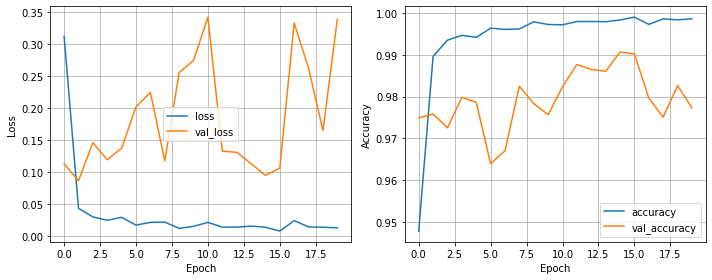

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

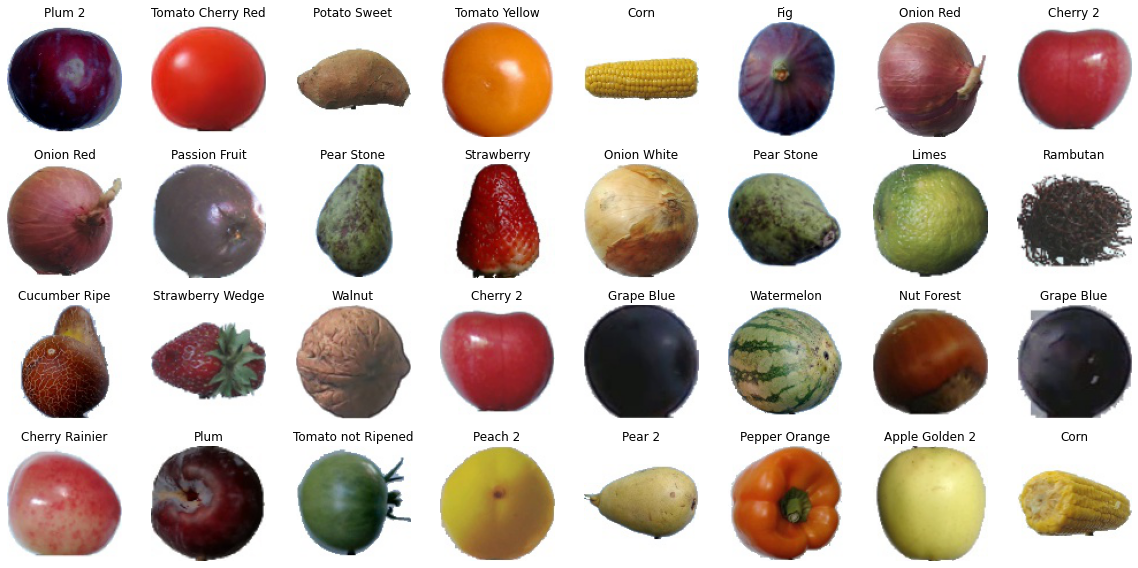

In [ ]:
indices_class = {v:name for name,v in train_generator.class_indices.items()}

(X,y)=train_generator.next()

plt.figure(figsize=(16,8))
for i in range(X.shape[0]):
    plt.subplot(4,8,i+1)
    plt.imshow(deprocess_img(X[i]))
    plt.title(indices_class[int(y[i])])
    plt.axis(False)
plt.tight_layout()    
plt.show()        

In [ ]:
import numpy as np
(X,y)=test_generator.next()
py   = fruit_model.predict(X)
plt.figure(figsize=(16,32))
for i in range(X.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(deprocess_img(X[i]))
    plt.title(indices_class[np.argmax(py[i])]+'/'+indices_class[int(y[i])])
    plt.axis(False)
plt.tight_layout()    
plt.show()   

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_generator.reset()
loss,acc = mod.evaluate(test_generator,verbose=0)
print('loss : {:.4f} , acuracy : {:.4f}'.format(loss,acc))